In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("tf version:",tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

tf version: 2.9.0


In [2]:
dfss = pd.read_parquet(r"D:\RND\Machine_Learning\Datasets/clean_dataset_ml_50_id.parquet")
dfss.fillna(0,inplace=True)
df = dfss.copy()
df['creation_time'] = pd.to_datetime(df['creation_time'])
df.set_index(['creation_time'],drop= True, inplace= True)
df["min"] = df.index.minute
df.sort_index(inplace=True)
df.reset_index(drop=True,inplace=True)
df

,temperature_2m,relative_humidity_2m,apparent_temperature,wind_speed_10m,wind_speed_100m,consumed_unit,lag1,lag2,lag3,lag4,lag5,day,hour,month,dayofweek,dayofyear,label_sensor_id,min
0,12.1,95,10.8,11.4,21.6,0.0,0.00,0.00,0.00,0.00,0.000,1,0,1,0,1,0,15
1,7.4,97,5.2,10.0,19.6,0.0,0.00,0.00,0.00,0.00,0.000,1,0,1,0,1,15,15
2,10.5,79,7.0,18.5,32.1,2.0,0.00,0.00,0.00,0.00,0.000,1,0,1,0,1,12,15
3,7.6,95,4.9,13.3,25.2,0.0,0.00,0.00,0.00,0.00,0.000,1,0,1,0,1,45,15
4,7.7,95,5.1,12.1,23.7,0.0,0.00,0.00,0.00,0.00,0.000,1,0,1,0,1,11,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225618,17.0,37,13.3,13.5,25.2,0.3,0.29,0.31,2.90,2.70,0.045,25,23,2,6,56,30,0
225619,17.0,37,13.4,12.7,24.8,13.6,13.85,13.69,2.40,2.74,7.600,25,23,2,6,56,29,0
225620,18.7,39,14.6,19.1,34.9,0.1,0.00,0.10,0.00,0.10,0.000,25,23,2,6,56,27,0
225621,17.1,33,12.4,18.6,31.4,0.0,0.20,0.10,0.10,0.30,0.400,25,23,2,6,56,23,0


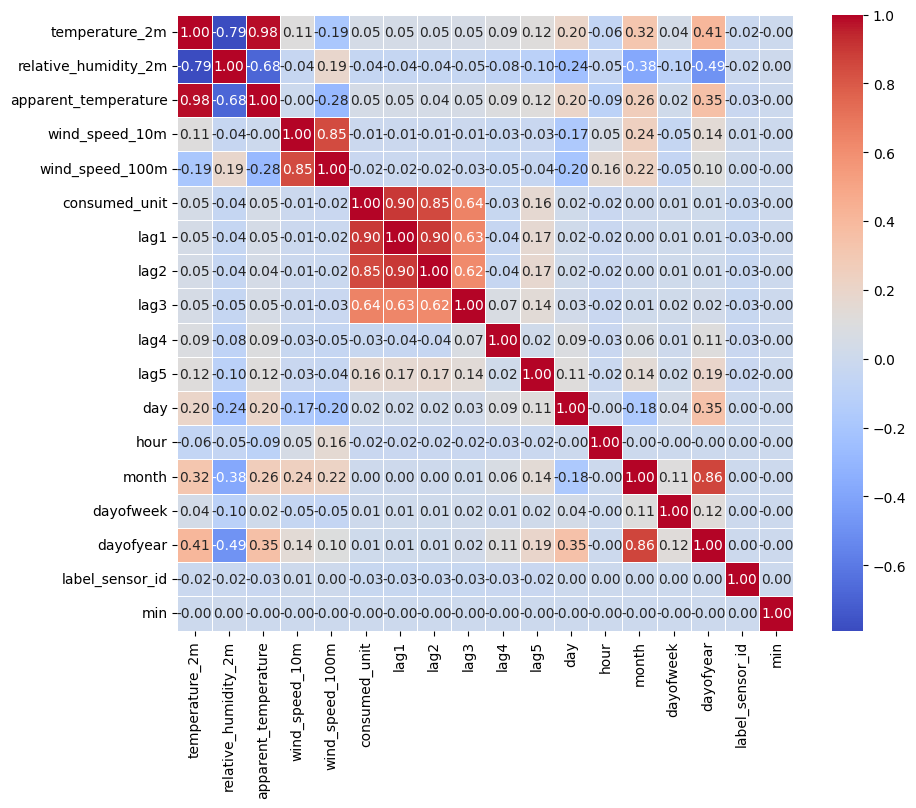

In [63]:
correlation_matrix = df.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)

# Show the plot
plt.show()

In [3]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
# val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.8):]
print("train_df:",len(train_df),"test_df:",len(test_df))
num_features = df.shape[1]
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('consumed_unit')
test_labels = test_features.pop('consumed_unit')

train_df: 180498 test_df: 45125


In [4]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [5]:
# df.describe().transpose()
train_features.describe()[1:3]

,temperature_2m,relative_humidity_2m,apparent_temperature,wind_speed_10m,wind_speed_100m,lag1,lag2,lag3,lag4,lag5,day,hour,month,dayofweek,dayofyear,label_sensor_id,min
mean,16.235442,52.931174,13.682448,10.629929,16.867375,1.940022,1.939779,1.897168,1.630743,1.293525,13.355289,11.456404,1.307754,2.871666,22.895666,25.261693,22.499335
std,5.279719,22.090460,5.456108,3.842634,7.116558,3.865708,3.865593,3.836244,3.616248,3.303312,8.718266,6.905829,0.461565,2.010468,12.923274,15.803963,16.768103


In [6]:
normalizer.variables

[<tf.Variable 'mean:0' shape=(17,) dtype=float32, numpy=
 array([16.235, 52.931, 13.682, 10.63 , 16.867,  1.94 ,  1.94 ,  1.897,
         1.631,  1.294, 13.355, 11.456,  1.308,  2.872, 22.896, 25.262,
        22.499], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(17,) dtype=float32, numpy=
 array([ 27.875, 487.981,  29.769,  14.766,  50.645,  14.944,  14.943,
         14.717,  13.077,  10.912,  76.007,  47.69 ,   0.213,   4.042,
        167.01 , 249.763, 281.163], dtype=float32)>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=180498>]

In [66]:
# first = np.array(train_features[:1])
# with np.printoptions(precision=2, suppress=True):
#     print('First example:', first)
#     print('Normalized:', normalizer(first).numpy())

In [7]:
test_results={}

In [65]:
def compile_and_fit(model,
                    train_features = train_features,
                    train_labels = train_labels, 
                    patience=5,
                    batch_size = None,
                    MAX_EPOCHS = 20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(train_features,train_labels, epochs=MAX_EPOCHS,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=1,
                        )
    return history


In [66]:
# linear_model = tf.keras.Sequential([
#     normalizer,
#     layers.Dense(64, activation='relu',input_shape=(17,)),
#     layers.Dense(units=1)
# ])
# linear_model.compile(optimizer='adam', loss='mean_squared_error')

model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu',input_shape=(17,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)])

history = compile_and_fit(model,train_features,train_labels,batch_size= 32)

Epoch 1/20
4513/4513 [==============================] - 6s 1ms/step - loss: 2.9782 - mean_absolute_error: 0.7107 - val_loss: 2.1648 - val_mean_absolute_error: 0.5917
Epoch 2/20
4513/4513 [==============================] - 5s 1ms/step - loss: 2.7621 - mean_absolute_error: 0.6628 - val_loss: 2.0305 - val_mean_absolute_error: 0.6028
Epoch 3/20
4513/4513 [==============================] - 5s 1ms/step - loss: 2.6727 - mean_absolute_error: 0.6478 - val_loss: 2.0578 - val_mean_absolute_error: 0.5685
Epoch 4/20
4513/4513 [==============================] - 5s 1ms/step - loss: 2.6154 - mean_absolute_error: 0.6409 - val_loss: 2.0406 - val_mean_absolute_error: 0.5786
Epoch 5/20
4513/4513 [==============================] - 5s 1ms/step - loss: 2.5761 - mean_absolute_error: 0.6351 - val_loss: 2.0784 - val_mean_absolute_error: 0.6094
Epoch 6/20
4513/4513 [==============================] - 5s 1ms/step - loss: 2.5540 - mean_absolute_error: 0.6308 - val_loss: 2.0628 - val_mean_absolute_error: 0.5805
Epoc

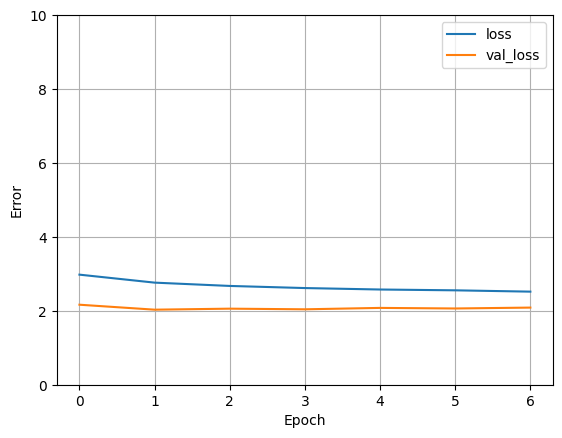

In [67]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
  
plot_loss(history)

In [81]:
def training_score(history):
    print(f"training_score:loss:{history.history['loss'][-1]:.3f},mae:{history.history['mean_absolute_error'][-1]:.3f}")

In [82]:
def evaluate(model,test_features= test_features,test_labels= test_labels):
    score = model.evaluate(test_features,test_labels,verbose=0)
    print("test_score:",score)
    return score
training_score(history)
score = evaluate(model)    

training_score:loss:2.518,mae:0.627
test_score: [2.5509064197540283, 0.6465504169464111]


In [85]:
def prediction(model, input_data,verbose=1):
    y_pred = model.predict(input_data,verbose)
    # Calculate MAE, MSE, and R²
    mae = mean_absolute_error(test_labels, y_pred)
    mse = mean_squared_error(test_labels, y_pred)
    r2 = r2_score(test_labels, y_pred)
    print(f"mae: {mae:.3f}")
    print(f"mse: {mse:.3f}")
    print(f"R2: {r2:.3f}")
    return y_pred

predicted_value = prediction(model,test_features)

45125/45125 [==============================] - 28s 614us/step
mae: 0.647
mse: 2.551
R2: 0.836


In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu',input_shape= (17,)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
model.compile(loss='mean_absolute_error',
      # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
      optimizer=tf.keras.optimizers.Adam(0.001),
      metrics=['mean_squared_error',])
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)

In [11]:
# Get the mean and variance from the normalizer
# mean = normalizer.mean.numpy()
# variance = normalizer.variance.numpy()
# std_dev = np.sqrt(variance)

# Denormalize the predictions
# y_pred_denormalized = y_pred * std_dev[-1] + mean[-1]  # Assuming normalization was done on the last axis


In [70]:
first_dense_layer = model.layers[1]  
weights, biases = first_dense_layer.get_weights()
print("Weights shape:", weights.shape)
feature_importance = np.abs(weights).mean(axis=1)
for i, importance in enumerate(feature_importance):
    print(f"Feature {train_features.columns[i]}: Importance {importance}")

Weights shape: (17, 64)
Feature temperature_2m: Importance 0.12255382537841797
Feature relative_humidity_2m: Importance 0.13486257195472717
Feature apparent_temperature: Importance 0.12379976361989975
Feature wind_speed_10m: Importance 0.10637343674898148
Feature wind_speed_100m: Importance 0.13217607140541077
Feature lag1: Importance 0.31067055463790894
Feature lag2: Importance 0.2993902564048767
Feature lag3: Importance 0.23547868430614471
Feature lag4: Importance 0.17139996588230133
Feature lag5: Importance 0.1330728679895401
Feature day: Importance 0.13349777460098267
Feature hour: Importance 0.15628020465373993
Feature month: Importance 0.17871850728988647
Feature dayofweek: Importance 0.17254233360290527
Feature dayofyear: Importance 0.15358757972717285
Feature label_sensor_id: Importance 0.13485142588615417
Feature min: Importance 0.13316363096237183


In [71]:
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)
result = permutation_importance(model, test_features, test_labels, 
                                n_repeats=10, random_state=42, 
                                scoring=custom_scorer)
sorted_idx = result.importances_mean.argsort()
for i in sorted_idx[::-1]:
    print(f"Feature {train_features.columns[i]}: Importance {result.importances_mean[i]:.8f}")

1411/1411 [==============================] - 1s 664us/step
Feature lag1: Importance 1.11899272
Feature lag3: Importance 0.06785002
Feature lag2: Importance 0.05458021
Feature temperature_2m: Importance 0.01111151
Feature apparent_temperature: Importance 0.00612706
Feature dayofweek: Importance 0.00429194
Feature wind_speed_10m: Importance 0.00278336
Feature lag4: Importance 0.00181942
Feature hour: Importance 0.00151673
Feature relative_humidity_2m: Importance 0.00102944
Feature label_sensor_id: Importance 0.00052258
Feature min: Importance 0.00031123
Feature month: Importance 0.00000000
Feature day: Importance -0.00001787
Feature wind_speed_100m: Importance -0.00015864
Feature lag5: Importance -0.00022037
Feature dayofyear: Importance -0.00037250


In [72]:
test_results['linear_model'] = model.evaluate(
    test_features, test_labels, verbose=0)

In [73]:
test_results

{'linear_model': [2.5509064197540283, 0.6465504169464111]}

In [44]:

model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu',input_shape=(17,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)])

model.compile(loss='mean_absolute_error',
      # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
      optimizer=tf.keras.optimizers.Adam(0.001),
      metrics=['mean_squared_error',])


## with SGD

In [43]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.6082 - mean_squared_error: 3.2249 - mean_absolute_percentage_error: 122466136.0000 - val_loss: 0.6039 - val_mean_squared_error: 2.4309 - val_mean_absolute_percentage_error: 72799728.0000
Epoch 2/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5728 - mean_squared_error: 3.0927 - mean_absolute_percentage_error: 108785408.0000 - val_loss: 0.4927 - val_mean_squared_error: 2.1764 - val_mean_absolute_percentage_error: 86439752.0000
Epoch 3/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5559 - mean_squared_error: 3.0275 - mean_absolute_percentage_error: 103650776.0000 - val_loss: 0.5009 - val_mean_squared_error: 2.2909 - val_mean_absolute_percentage_error: 93149344.0000
Epoch 4/10
4513/4513 [==============================] - 21s 5ms/step - loss: 0.5513 - mean_squared_error: 2.9900 - mean_absolute_percentage_error: 103141232.0000 - val_loss: 0.4925 - val_mean_squared_er

### with adam

In [45]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5977 - mean_squared_error: 3.1802 - val_loss: 0.5138 - val_mean_squared_error: 2.2968
Epoch 2/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5487 - mean_squared_error: 3.0303 - val_loss: 0.5098 - val_mean_squared_error: 2.2528
Epoch 3/10
4513/4513 [==============================] - 11s 2ms/step - loss: 0.5362 - mean_squared_error: 2.9998 - val_loss: 0.4855 - val_mean_squared_error: 2.2707
Epoch 4/10
4513/4513 [==============================] - 10s 2ms/step - loss: 0.5261 - mean_squared_error: 2.9381 - val_loss: 0.4865 - val_mean_squared_error: 2.2423
Epoch 5/10
4513/4513 [==============================] - 11s 3ms/step - loss: 0.5196 - mean_squared_error: 2.8865 - val_loss: 0.4681 - val_mean_squared_error: 2.1978
Epoch 6/10
4513/4513 [==============================] - 12s 3ms/step - loss: 0.5152 - mean_squared_error: 2.8441 - val_loss: 0.4676 - val_mean_squared_error: 2.1715
Epoch 7/10

In [46]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 dense_20 (Dense)            (None, 64)                1152      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,412
Trainable params: 5,377
Non-trainable params: 35
_________________________________________________________________
